In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('311_Cases.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471061 entries, 0 to 4471060
Data columns (total 47 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   CaseID                                                int64  
 1   Opened                                                object 
 2   Closed                                                object 
 3   Updated                                               object 
 4   Status                                                object 
 5   Status Notes                                          object 
 6   Responsible Agency                                    object 
 7   Category                                              object 
 8   Request Type                                          object 
 9   Request Details                                       object 
 10  Address                                               object 
 11  Street     

In [4]:
# Remove unnecessary columns...
df.drop(columns=df.columns[24:47],inplace=True)

In [5]:
# Pull out only overflowing trash:
trash = df[(df['Category']=='Street and Sidewalk Cleaning') & 
                     (df['Request Type']=='Overflowing_City_Receptacle_or_Dumpster')]

In [6]:
# Create response time and day opened and closed columns:
trash.loc[:,['Opened','Closed']] = trash.loc[:,['Opened','Closed']].apply(pd.to_datetime,format="%m/%d/%Y %I:%M:%S %p")
trash['Resolution Time'] = (trash['Closed']-trash['Opened']).dt.seconds/60 # minutes
trash['Day Opened'] = trash['Opened'].dt.day_name()
trash['Day Closed'] = trash['Closed'].dt.day_name()

C:\Users\donah\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\donah\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\donah\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [7]:
pd.unique(trash['Day Closed'])
# trash[trash['Day Opened']=='Nan']

array(['Saturday', 'Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Friday',
       'Thursday', nan], dtype=object)

### Looking at trash compliants by day of week and neighborhood:

In [8]:
complaints = pd.pivot_table(trash[['Supervisor District','Day Opened','Resolution Time']],values='Resolution Time',index = 'Supervisor District',columns='Day Opened',aggfunc='count')
cols = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
complaints = complaints[cols]
complaints.drop(index=0,inplace=True)

In [9]:
complaints

Day Opened,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Supervisor District,,,,,,,
1.0,159.0,111.0,126.0,135.0,136.0,99.0,164.0
2.0,81.0,58.0,49.0,40.0,50.0,72.0,101.0
3.0,155.0,140.0,115.0,158.0,155.0,167.0,257.0
4.0,128.0,92.0,61.0,72.0,57.0,62.0,168.0
5.0,169.0,129.0,108.0,115.0,121.0,131.0,220.0
6.0,219.0,176.0,182.0,201.0,269.0,180.0,231.0
7.0,79.0,65.0,69.0,67.0,59.0,43.0,72.0
8.0,271.0,188.0,210.0,181.0,188.0,168.0,256.0
9.0,170.0,108.0,120.0,112.0,99.0,110.0,211.0


Text(0.5, 1.0, 'Overflowing Trash Complaints (by district)')

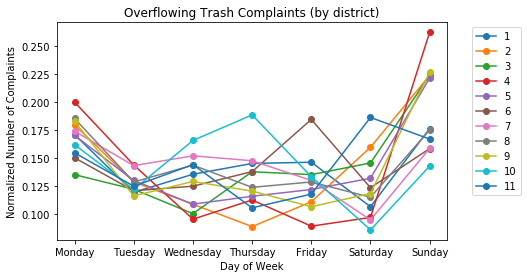

In [10]:
# Interesting that most increase on Sunday
# District 4, 10, 6 see interesting differences in patterns

plt.figure(figsize=(7,4))
plt.plot(complaints.T/complaints.T.sum(),marker='o')
plt.legend(range(1,12),bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
plt.xlabel('Day of Week')
plt.ylabel('Normalized Number of Complaints')
plt.title('Overflowing Trash Complaints (by district)')

### Let's grab MUNI stop locations and get proximity to nearest stop

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3961 # Radius of Earth in miles
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = R * c
    return total_miles



In [13]:
muni = pd.read_csv('Muni_Stops.csv')

In [14]:
muni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3593 entries, 0 to 3592
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OBJECTID                      3593 non-null   int64  
 1   STOPNAME                      3593 non-null   object 
 2   TRAPEZESTOPABBR               3593 non-null   object 
 3   RUCUSSTOPABBR                 3234 non-null   object 
 4   STOPID                        3593 non-null   int64  
 5   LATITUDE                      3593 non-null   float64
 6   LONGITUDE                     3593 non-null   float64
 7   ACCESSIBILITYMASK             3450 non-null   float64
 8   ATSTREET                      3501 non-null   object 
 9   ONSTREET                      3581 non-null   object 
 10  POSITION                      3217 non-null   object 
 11  ORIENTATION                   3252 non-null   object 
 12  SERVICEPLANNINGSTOPTYPE       1781 non-null   object 
 13  SHE

## Let's look at each district by month to see whether there are any interesting trends:

In [15]:
# First, get month and year of Opened complaint in dataframe:
trash.head()
trash['Month'] = pd.DatetimeIndex(trash['Opened']).month
trash['Year'] = pd.DatetimeIndex(trash['Opened']).year
trash.columns

C:\Users\donah\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\donah\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Index(['CaseID', 'Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
       'Responsible Agency', 'Category', 'Request Type', 'Request Details',
       'Address', 'Street', 'Supervisor District', 'Neighborhood',
       'Police District', 'Latitude', 'Longitude', 'Point', 'Source',
       'Media URL', 'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       'Resolution Time', 'Day Opened', 'Day Closed', 'Month', 'Year'],
      dtype='object')

In [16]:
# Create pivot table for complaints by district and 
complaints = pd.pivot_table(trash[['Supervisor District','Month','Resolution Time']],values='Resolution Time',index = 'Supervisor District',columns='Month',aggfunc='count')
cols = ['January','February','March','April','May','June','July','August','September','October','November','December']
complaints.columns = cols
complaints.drop(index=0,inplace=True)
complaints

,January,February,March,April,May,June,July,August,September,October,November,December
Supervisor District,,,,,,,,,,,,
1.0,111.0,64.0,50.0,50.0,89.0,45.0,79.0,85.0,94.0,74.0,70.0,119.0
2.0,38.0,28.0,24.0,29.0,34.0,28.0,57.0,39.0,39.0,60.0,36.0,39.0
3.0,114.0,80.0,55.0,50.0,63.0,83.0,117.0,132.0,108.0,136.0,93.0,116.0
4.0,96.0,36.0,25.0,49.0,38.0,32.0,57.0,72.0,57.0,70.0,44.0,64.0
5.0,117.0,62.0,49.0,74.0,78.0,75.0,79.0,95.0,100.0,91.0,81.0,92.0
6.0,105.0,91.0,106.0,104.0,121.0,111.0,163.0,136.0,146.0,157.0,99.0,119.0
7.0,72.0,40.0,28.0,27.0,32.0,19.0,32.0,34.0,31.0,53.0,42.0,44.0
8.0,170.0,99.0,110.0,114.0,82.0,103.0,144.0,107.0,172.0,153.0,99.0,109.0
9.0,105.0,68.0,72.0,65.0,60.0,58.0,79.0,70.0,113.0,78.0,79.0,83.0


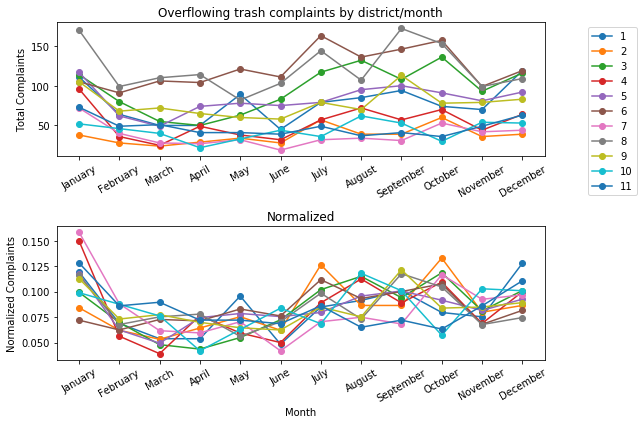

In [17]:
# Plot each district trend over the year:
fig, axs = plt.subplots(2,1,figsize=(9,6))
axs[0].plot(complaints.T,marker='o')
axs[0].set_title('Overflowing trash complaints by district/month')
axs[0].set_ylabel('Total Complaints')
axs[0].set_xticklabels(complaints.columns,rotation=30)
axs[1].plot(complaints.T/complaints.T.sum(),marker='o')
axs[1].set_xlabel('Month')
axs[1].set_title('Normalized')
axs[1].set_xticklabels(complaints.columns,rotation=30)
axs[1].set_ylabel('Normalized Complaints')
axs[0].legend(range(1,12),bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
plt.tight_layout()

### Some interesting points:
- Disricts 6,8,3 are high complainers: (Hayes Valley, Nob Hill/North Beach, Lake Shore). Do they have more of a problem or are they more gentrified? 
- January is a high complaint month compared to other months (prob due to holidays: being home more and trash from Christmas)
### Next plots:
- Count of total complaints by district will look very interesting
- How do counts grow by year by district?

### Total complaints by district: barplot:

In [31]:
complaints = pd.pivot_table(trash[['Supervisor District','Year','Resolution Time']],values='Resolution Time',index = 'Supervisor District',columns='Year',aggfunc='count')
complaints.drop(index=0,inplace=True)
complaints.index

Float64Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0], dtype='float64', name='Supervisor District')

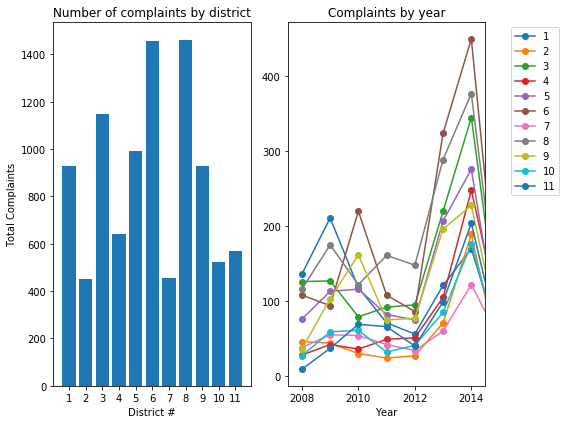

In [53]:
# plot total by district and break down by year:
fig, axs = plt.subplots(1,2,figsize=(8,6))
xticks = list(complaints.index)
axs[0].bar(x=complaints.index,height=complaints.T.sum())
axs[0].set_title('Number of complaints by district')
axs[0].set_ylabel('Total Complaints')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('District #')
axs[1].plot(complaints.T,marker='o')
axs[1].set_xlim(2007.5,2014.5)
axs[1].set_xlabel('Year')
axs[1].set_title('Complaints by year')
axs[1].legend(range(1,12),bbox_to_anchor=(1.4, 1), loc='upper right', ncol=1)
plt.tight_layout()

### Below is example of trash response times by neighborhood:

In [ ]:
neighborhood_trash = pd.pivot_table(trash,index = 'Supervisor District',values = 'Resolution Time',columns='Day Opened')
cols = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
neighborhood_trash = neighborhood_trash[cols]
neighborhood_trash.drop(index=-1,inplace=True)

In [ ]:
neighborhood_trash

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(neighborhood_trash.T)
plt.legend(range(1,12),bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
plt.xlabel('Day of Week')
plt.ylabel('Minutes to Resolution')
plt.title('Overflowing Trash Complaint Resolution Time (by district)')

In [ ]:
import folium
trash_coords = trash_can[['Latitude','Longitude']].to_numpy()
SF_COORDINATES = (37.76, -122.45)
m = folium.Map(
    SF_COORDINATES,
    zoom_start=13
)


for each in trash_coords:
    folium.CircleMarker(
        location = (each[0],each[1]),
        radius = 1).add_to(m)
  
display(m)

# Scatterplot of distance to muni and complaints! 
- This has a function dist_to_munistop which calculates distance to nearest muni stop. It is slow and could use a better algorithm.
- Also note that there are many entries with Lat,Lon = 0.0 which need to be cleaned! 

In [ ]:
# This is correct, I think. More compact and faster but still slow (need algorithm to divide and conquer maybe?)
def dist_to_munistop(lat1, lon1):
    muni_coords = [tuple(x) for x in muni[['LATITUDE','LONGITUDE']].values]
    x = [haversine(test_coord[0],test_coord[1],lat1,lon1) for test_coord in muni_coords]
    return x[np.argmin(x)] # distance from closest muni stop (miles)

trash['Muni Distance'] = [dist_to_munistop(x[0],x[1]) for x in trash[['Latitude','Longitude']].values]



In [ ]:
# This is pretty cool, showing that complaints are more frequent closer to MUNI stops
# However, it could also be that trash cans are placed near muni stops
trash.loc[trash['Muni Distance']>7000,'Muni Distance'] = np.nan
sns.distplot(trash['Muni Distance'],bins=60)
plt.show()